<a href="https://colab.research.google.com/github/meutiajasmine/skripsi/blob/main/finetune_videoMAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorchvideo transformers evaluate -q
!git config --global credential.helper store

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.9 MB/s eta 0:00:00


In [2]:
from transformers.utils import send_example_telemetry

send_example_telemetry("video_classification_notebook", framework="pytorch")

# Load Dataset

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/skripsi/split_dataset/"

Mounted at /content/drive


In [4]:
!find {dataset_path} | head -5

/content/drive/MyDrive/skripsi/split_dataset/
/content/drive/MyDrive/skripsi/split_dataset/train
/content/drive/MyDrive/skripsi/split_dataset/train/1_mengangguk
/content/drive/MyDrive/skripsi/split_dataset/train/1_mengangguk/1_1.mp4
/content/drive/MyDrive/skripsi/split_dataset/train/1_mengangguk/1_2.mp4


In [5]:
import pathlib

dataset_root_path = pathlib.Path(dataset_path)

In [6]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.mp4")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.mp4")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.mp4")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 333


In [7]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.mp4"))
    + list(dataset_root_path.glob("val/*/*.mp4"))
    + list(dataset_root_path.glob("test/*/*.mp4"))
)
all_video_file_paths[:5]

[PosixPath('/content/drive/MyDrive/skripsi/split_dataset/train/1_mengangguk/1_1.mp4'),
 PosixPath('/content/drive/MyDrive/skripsi/split_dataset/train/1_mengangguk/1_2.mp4'),
 PosixPath('/content/drive/MyDrive/skripsi/split_dataset/train/1_mengangguk/1_3.mp4'),
 PosixPath('/content/drive/MyDrive/skripsi/split_dataset/train/1_mengangguk/1_4.mp4'),
 PosixPath('/content/drive/MyDrive/skripsi/split_dataset/train/1_mengangguk/1_5.mp4')]

In [8]:
class_labels = sorted({str(path).split("/")[-2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['1_mengangguk', '2_mengangkat_tangan', '3_menggunakan_hp', '4_menopang_kepala', '5_menunduk'].


# Loading The Model

In [9]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 8 # batch size for training and evaluation

image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/377M [00:00<?, ?B/s]

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
image_processor

VideoMAEImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "VideoMAEImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [11]:
model

VideoMAEForVideoClassification(
  (videomae): VideoMAEModel(
    (embeddings): VideoMAEEmbeddings(
      (patch_embeddings): VideoMAEPatchEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
    )
    (encoder): VideoMAEEncoder(
      (layer): ModuleList(
        (0-11): 12 x VideoMAELayer(
          (attention): VideoMAESdpaAttention(
            (attention): VideoMAESdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): VideoMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VideoMAEIntermediate(
            (den

In [12]:
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 86,231,045 | trainable_params = 86,231,045


In [13]:
import torchvision
import pytorchvideo.data
from torchvision.transforms import functional
import sys

sys.modules["torchvision.transforms.functional_tensor"] = functional

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [14]:
import os

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps


# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [15]:
# We can access the `num_videos` argument to know the number of videos we have in the
# dataset.
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(264, 33, 36)

In [16]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [17]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_name 1_43.mp4
video_index 30
clip_index 0
aug_index 0
label 0
Video label: 1_mengangguk


In [18]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

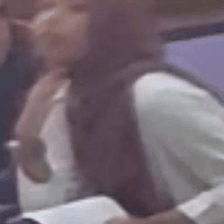

In [19]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

# Training The Model

In [57]:
from copy import deepcopy  # ✅ Import deepcopy from copy module

# ✅ Custom Callback untuk mencatat Train Accuracy
class CustomTrainAccuracyCallback(TrainerCallback):
    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer

    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            train_metrics = self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            state.log_history.append(train_metrics)  # ✅ Simpan train accuracy ke log_history
            return control_copy

In [58]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt
import os
import torch

# Callback untuk menyimpan model terbaik dan loss
class SaveBestModelCallback(TrainerCallback):
    def __init__(self, save_path, metric_name='eval_accuracy'):
        super().__init__()
        self.best_metric = -float('inf')  # Menyimpan metrik terbaik
        self.metric_name = metric_name
        self.save_path = save_path
        self.train_losses = []  # Menyimpan training loss per epoch
        self.eval_losses = []   # Menyimpan validation loss per epoch
        self.train_accuracies = []  # Menyimpan training accuracy per epoch
        self.eval_accuracies = []   # Menyimpan validation accuracy per epoch
        os.makedirs(self.save_path, exist_ok=True)

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        if 'eval_loss' in metrics:
            self.eval_losses.append(metrics['eval_loss'])
        if 'eval_accuracy' in metrics:
            self.eval_accuracies.append(metrics['eval_accuracy'])  # ✅ Fix here!

        # Simpan model terbaik berdasarkan metrik yang dipilih
        if self.metric_name in metrics and metrics[self.metric_name] > self.best_metric:
            self.best_metric = metrics[self.metric_name]
            model_path = os.path.join(self.save_path, "pretrained_best_model.pt")
            torch.save(kwargs['model'].state_dict(), model_path)
            print(f"Model terbaik disimpan di {model_path} dengan {self.metric_name}: {self.best_metric:.4f}")

    def on_epoch_end(self, args, state, control, **kwargs):
        """Dipanggil setelah setiap epoch selesai untuk mencatat loss dan accuracy"""
        if state.log_history:
            last_log = state.log_history[-1]  # Get latest log
            if "loss" in last_log:  # ✅ "loss" is the actual key for train loss
                self.train_losses.append(last_log["loss"])
            if "train_accuracy" in last_log:
                self.train_accuracies.append(last_log["train_accuracy"])

        # ✅ Ensure losses exist before plotting
        if self.train_losses or self.eval_losses:
            plt.figure(figsize=(10, 5))
            plt.plot(range(1, len(self.train_losses) + 1), self.train_losses, label="Train Loss")
            plt.plot(range(1, len(self.eval_losses) + 1), self.eval_losses, label="Validation Loss")
            plt.title("Train & Validation Loss per Epoch")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid(True)
            loss_path = os.path.join(self.save_path, "train_val_loss.png")
            plt.savefig(loss_path)
            plt.close()
            print(f"Grafik Train & Validation Loss disimpan di {loss_path}")

        # ✅ Ensure accuracies exist before plotting
        if self.train_accuracies or self.eval_accuracies:
            plt.figure(figsize=(10, 5))
            plt.plot(range(1, len(self.train_accuracies) + 1), self.train_accuracies, label="Train Accuracy")
            plt.plot(range(1, len(self.eval_accuracies) + 1), self.eval_accuracies, label="Validation Accuracy")
            plt.title("Train & Validation Accuracy per Epoch")
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.grid(True)
            accuracy_path = os.path.join(self.save_path, "train_val_accuracy.png")
            plt.savefig(accuracy_path)
            plt.close()
            print(f"Grafik Train & Validation Accuracy disimpan di {accuracy_path}")


In [59]:
import evaluate
import numpy as np

# Load evaluasi metrik
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

In [60]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    # Menghitung accuracy
    accuracy_score = accuracy.compute(predictions=predictions, references=labels)

    # Menghitung F1 score
    f1_score = f1.compute(predictions=predictions, references=labels, average='weighted')

    # Menghitung precision
    precision_score = precision.compute(predictions=predictions, references=labels, average='weighted')

    # Menghitung recall
    recall_score = recall.compute(predictions=predictions, references=labels, average='weighted')

    # Menggabungkan semua metrik
    metrics = {
        'accuracy': accuracy_score['accuracy'],
        'f1': f1_score['f1'],
        'precision': precision_score['precision'],
        'recall': recall_score['recall']
    }

    return metrics

In [61]:
import torch

def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [62]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-pretrained"
num_epochs = 4

args = TrainingArguments(
    output_dir="/content/drive/MyDrive/skripsi/videoMAE_pretrained/",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="no",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    push_to_hub=False,
    report_to="none",
    metric_for_best_model="eval_accuracy",
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [63]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    callbacks=[SaveBestModelCallback(save_path = '/content/drive/MyDrive/skripsi/videoMAE_pretrained/')]  # Add callback here
)

<ipython-input-63-1a9efe064f62>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [64]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
train_results = trainer.train()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,1.534378,0.311787,0.257645,0.257653,0.311787
1,No log,1.520311,0.368821,0.311019,0.308421,0.368821


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Grafik Train & Validation Accuracy disimpan di /content/drive/MyDrive/skripsi/videoMAE_pretrained/train_val_accuracy.png


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model terbaik disimpan di /content/drive/MyDrive/skripsi/videoMAE_pretrained/pretrained_best_model.pt dengan eval_accuracy: 0.3030


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Grafik Train & Validation Loss disimpan di /content/drive/MyDrive/skripsi/videoMAE_pretrained/train_val_loss.png
Grafik Train & Validation Accuracy disimpan di /content/drive/MyDrive/skripsi/videoMAE_pretrained/train_val_accuracy.png


In [30]:
trainer.evaluate(test_dataset)

{'eval_loss': 1.6129893064498901,
 'eval_accuracy': 0.2535211267605634,
 'eval_f1': 0.26527748868691076,
 'eval_precision': 0.2859707263186965,
 'eval_recall': 0.2535211267605634,
 'eval_runtime': 98.3013,
 'eval_samples_per_second': 0.722,
 'eval_steps_per_second': 0.092,
 'epoch': 3.25}

In [31]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

***** test metrics *****
  epoch                   =       3.25
  eval_accuracy           =     0.2535
  eval_f1                 =     0.2653
  eval_loss               =      1.613
  eval_precision          =      0.286
  eval_recall             =     0.2535
  eval_runtime            = 0:01:29.86
  eval_samples_per_second =       0.79
  eval_steps_per_second   =        0.1


# Inference

In [32]:
# Load saved weights from Drive
model_path = "/content/drive/MyDrive/skripsi/videoMAE_pretrained/pretrained_best_model.pt"  # Update the correct path
state_dict = torch.load(model_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.load_state_dict(state_dict)

# Set model to evaluation mode (important for inference)
model.eval()

print("Model successfully loaded for inference!")

<ipython-input-32-c2fb17eb5cee>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.device("cuda" if torch.cuda.is_availa

Model successfully loaded for inference!


In [33]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)

video torch.Size([3, 16, 224, 224])
video_name 4_21.mp4
video_index 23
clip_index 0
aug_index 0
label 3
Video label: 4_menopang_kepala


In [34]:
import torch

def run_inference(model, video, label=None):
    """Utility to run inference given a model and a preprocessed test video.

    Args:
        model (torch.nn.Module): The trained VideoMAE model.
        video (torch.Tensor): The preprocessed video tensor (frames, channels, height, width).
        label (Optional[int]): The ground truth label if available.

    Returns:
        torch.Tensor: Logits output from the model.
    """
    # Ensure the video tensor is in the correct shape (batch, channels, frames, height, width)
    video = video.permute(1, 0, 2, 3).unsqueeze(0)  # (C, F, H, W) → (1, C, F, H, W)

    # Prepare inputs
    inputs = {"pixel_values": video}

    if label is not None:
        inputs["labels"] = torch.tensor([label])

    # Move to device (GPU if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # Disable gradient calculation for inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # Raw model output

    return logits

# Load saved weights from Drive
model_path = "/content/drive/MyDrive/skripsi/videoMAE_pretrained/pretrained_best_model.pt"  # Update the correct path
state_dict = torch.load(model_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# ✅ Initialize model with the correct number of classes and labels
trained_model = VideoMAEForVideoClassification.from_pretrained(
    "MCG-NJU/videomae-base",  # Base model
    num_labels=len(id2label),  # Number of classes from your training data
    label2id=label2id,  # Label to ID mapping from your training data
    id2label=id2label,  # ID to label mapping from your training data
    ignore_mismatched_sizes=True, # ignore mismatched keys
)

trained_model.load_state_dict(state_dict)
trained_model.eval()  # Set to evaluation mode

print("Model successfully loaded for inference!")

# ✅ Get a sample video from the test dataset
sample_test_video = next(iter(test_dataset))  # Assuming test_dataset is an iterable dataset

# Extract video and label
video_tensor = sample_test_video["video"]  # Shape: (F, C, H, W)
label = sample_test_video.get("label", None)  # Get label if available

# ✅ Run inference
logits = run_inference(trained_model, video_tensor, label)

# ✅ Get the predicted class
predicted_class_idx = logits.argmax(-1).item()
predicted_class = trained_model.config.id2label[predicted_class_idx]

print(f"Predicted class: {predicted_class}")


<ipython-input-34-a16500ec64a2>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=torch.device("cuda" if torch.cuda.is_avail

Model successfully loaded for inference!
Predicted class: 2_mengangkat_tangan


# test

In [35]:
# Melakukan prediksi pada dataset validasi
predictions = trainer.predict(test_dataset)

# Mendapatkan logits dan label sebenarnya
logits = predictions.predictions
labels = predictions.label_ids

# Mendapatkan prediksi akhir dengan argmax
y_pred = np.argmax(logits, axis=1)
y_true = labels

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mlxtend.plotting import plot_confusion_matrix

<Figure size 1200x1000 with 0 Axes>

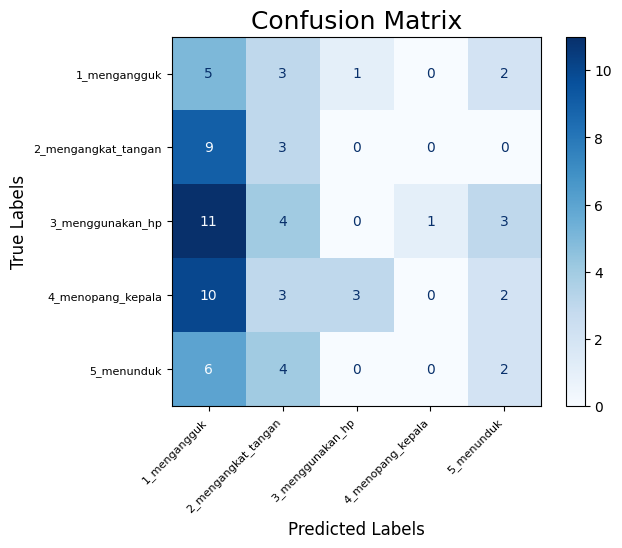

In [37]:
# Menghitung Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Mengatur ukuran gambar
plt.figure(figsize=(12, 10))

# Menampilkan Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id2label.values()))
disp.plot(cmap=plt.cm.viridis, values_format='d')

# Mengatur judul dan ukuran font
plt.title("Confusion Matrix", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=8)  # Ukuran font lebih kecil untuk sumbu x
plt.yticks(fontsize=8)  # Ukuran font lebih kecil untuk sumbu y
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

# Tampilkan plot
plt.show()